In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Попробуем применить кластеризацию для различения рукописных цифр.

In [116]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
print(X.shape) # размерность данных

(150L, 4L)


Посмотрим на разброс точек по каждой паре точек, где цветом обозначим истинную метку класса.

In [226]:
def pairplot(X, y, colors):
    fig, axes = plt.subplots(nrows=X.shape[1], ncols=X.shape[1], figsize=(15,15))

    for i in xrange(X.shape[1]):
        for j in xrange(X.shape[1]):
            if i == j:
                axes[i, j].hist(X[:, i], 15)
            else:
                axes[i, j].scatter(X[:, i], X[:, j], c=colors[y])
            if X.shape[1] - 1:
                axes[i, j].set_xlabel(j)
            if j == 0:
                axes[i, j].set_ylabel(i)

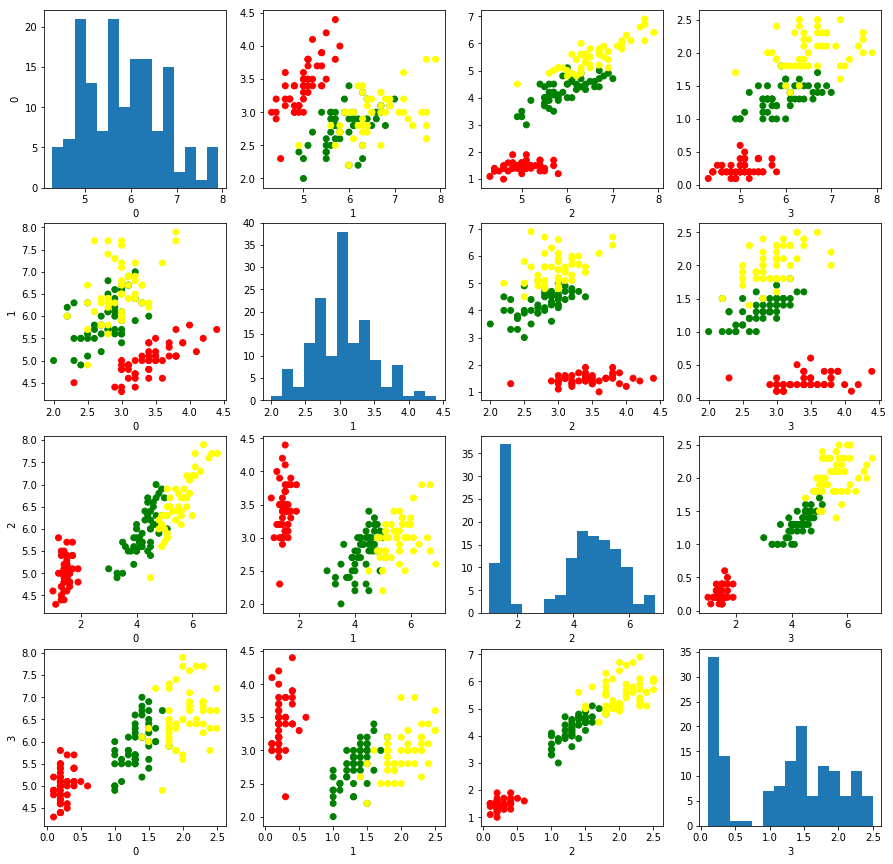

In [225]:
pairplot(X, y, np.array(['red', 'green', 'yellow']))

Далее будем подразумевать, что число классов нам не известно и проверим, способны ли алгоритмы кластеризации выделить 3 кластера.

# K-Means

Попробуем, для начала, применить метод k-средних для двух кластеров. Документация: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

In [118]:
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters=2, random_state=10, n_jobs=4, max_iter=1000)
y_pred2 = kmeans2.fit_predict(X)

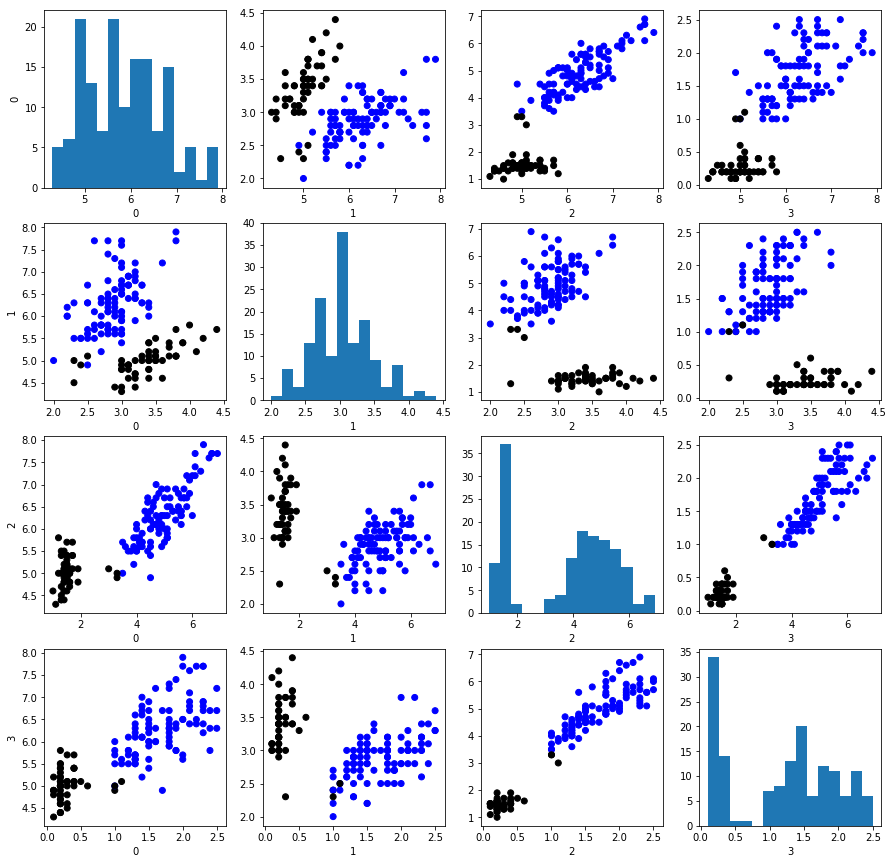

In [217]:
pairplot(X, y_pred2, np.array(['blue', 'black']))

Так как при решении задачи кластеризации, обычно, нет истинных меток классов, оценить качество кластеризации - не самая тривиальная задача. В sklearn для этой цели подходит две меры. Их и будем оценивать. Сравнение с истинными метками проведем в конце для всех рассмотренных в этой тетрадке методов кластеризации.

In [119]:
from sklearn.metrics import calinski_harabaz_score, silhouette_samples, silhouette_score
import matplotlib.cm as cm # для выбора цветовой палитры

def estimate_cluster(X, y_pred, name_of_alg=None):
    if not (name_of_alg is None):
        print(("Алгоритм: " + name_of_alg).decode('utf-8'))
    
    # Calinski-Harabaz - Отношение межкластерной дисперсии к внутрикластерной дисперсии
    # Чем больше, тем лучшше
    print("Calinski-Harabaz: %.4f" % calinski_harabaz_score(X, y_pred))

    silhouette_avg = silhouette_score(X, y_pred)
    print("Средний силуэт: %.4f" % silhouette_avg)

    n_clusters = len(np.unique(y_pred))

    # Покажем, как меняются силуэты в каждом кластере
    fig, ax1 = plt.subplots(figsize=(8,6))
    ax1.set_xlim([-0.1, 1])
    # 10 здесь необходима для того, чтобы оставлять пространство между силуэтами кластеров
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    sample_silhouette_values = silhouette_samples(X, y_pred)

    y_lower = 10
    # пройдем по всем кластерам
    for i in range(n_clusters):
        # Аггрегируем силуеты объетов, попавших в кластер i и сортируем их
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Выводим номер кластера
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Вычисляем новую нижнюю границу между силуетами кластеров
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Силуэты для разных кластеров.".decode('utf-8'))
    ax1.set_xlabel("Величина силуэта".decode('utf-8'))
    ax1.set_ylabel("Номер кластера".decode('utf-8'))

    # Вертикальная линия показывает среднее значение силуэта
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


Алгоритм: K-Means, 2 кластера
Calinski-Harabaz: 513.3038
Средний силуэт: 0.6808
Сумма квадратов расстояний до центров кластера: 152.3687


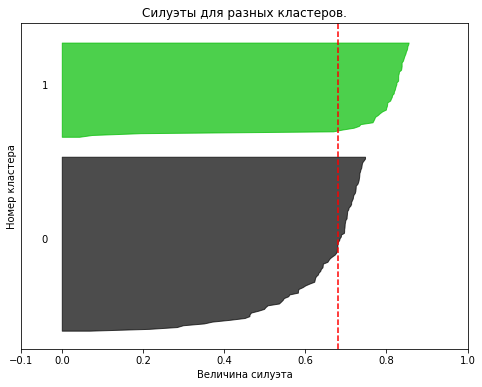

In [120]:
estimate_cluster(X, y_pred2, 'K-Means, 2 кластера')
print("Сумма квадратов расстояний до центров кластера: %.4f" % kmeans2.inertia_)

Получились достатчно неплохие силуэты. Но, может быть, можно улучшить результаты. Вомпользуемся методом локтя для выбора числа кластеров.

In [126]:
J = []
params = np.arange(1, 11)
for k in params:
    kmeans = KMeans(n_clusters=k, random_state=10, n_jobs=4, max_iter=1000)
    kmeans.fit(X)
    J.append(kmeans.inertia_)
J = np.array(J)

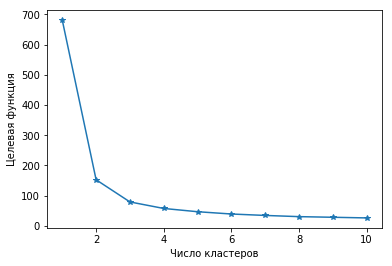

In [127]:
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Целевая функция'.decode('utf-8'))
plt.show()

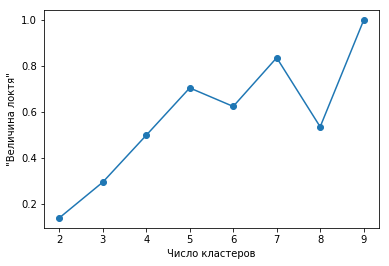

In [129]:
D = np.abs(J[1:-1]-J[2:])/np.abs(J[:-2] - J[1:-1])
plt.plot(params[1:-1], D, '-o')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('\"Величина локтя\"'.decode('utf-8'))
plt.show()

Самое низкое значение "величины локтя" соответствует 2 кластерам. Зная истинное число кластеров, давайте попробуем обучить K-Means для трех кластеров.

Алгоритм: K-Means, 3 кластера
Calinski-Harabaz: 560.3999
Средний силуэт: 0.5526
Сумма квадратов расстояний до центров кластера: 78.9408


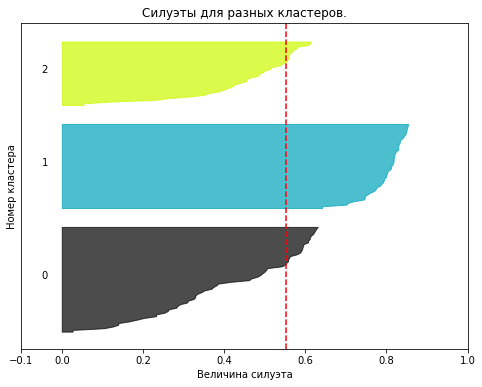

In [125]:
kmeans3 = KMeans(n_clusters=3, random_state=10, n_jobs=4, max_iter=1000)
y_pred3 = kmeans3.fit_predict(X)
estimate_cluster(X, y_pred3, 'K-Means, 3 кластера')
print("Сумма квадратов расстояний до центров кластера: %.4f" % kmeans3.inertia_)

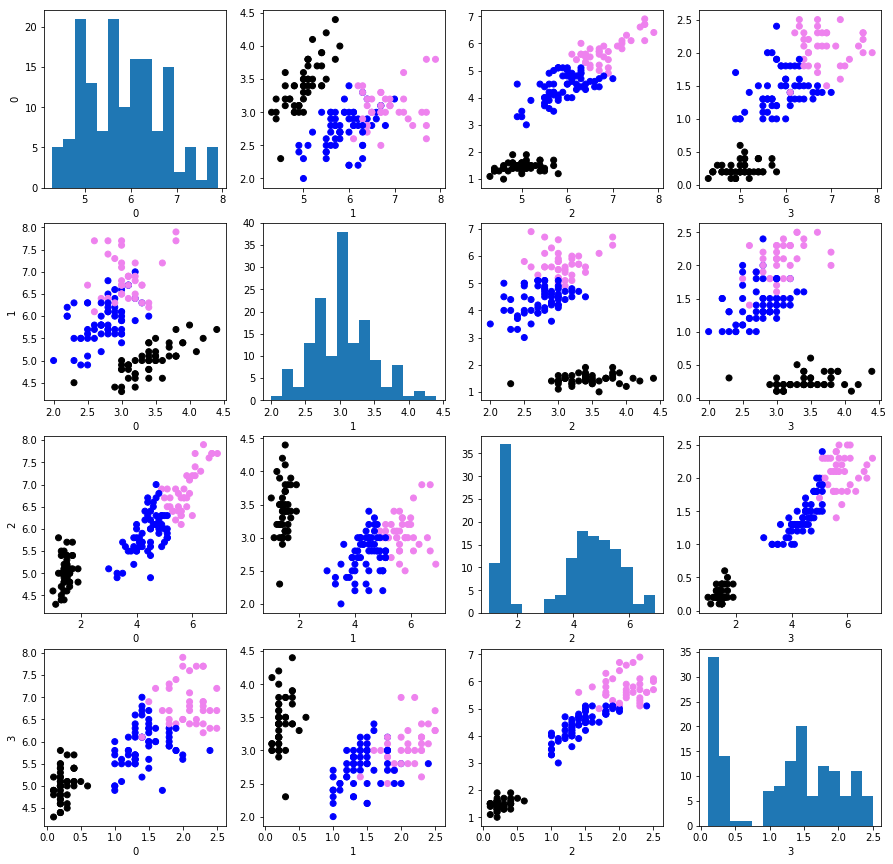

In [218]:
pairplot(X, y_pred3, np.array(['blue', 'black', 'violet']))

Средний силуэт снизился, что плохо, в то время как мера Calinski-Harabaz возросла, что хорошо.

Мы пытались применить правило локтя для целевой функции классификатора. То же самое можно попробовать сделать для каждой из мер. Для начала, для среднего силуэта.

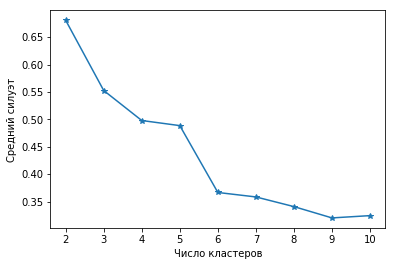

In [132]:
J = []
params = np.arange(2, 11)
for k in params:
    kmeans = KMeans(n_clusters=k, random_state=10, n_jobs=4, max_iter=1000)
    kmeans.fit(X)
    J.append(silhouette_score(X, kmeans.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Средний силуэт с ростом числа кластеров только убывает, т.е. 2 - оптимальное число класетров. То же самое проверим для другой меры.

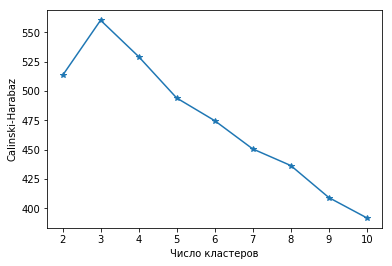

In [134]:
J = []
params = np.arange(2, 11)
for k in params:
    kmeans = KMeans(n_clusters=k, random_state=10, n_jobs=4, max_iter=1000)
    kmeans.fit(X)
    J.append(calinski_harabaz_score(X, kmeans.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

А в этом случае, выбор в пользу 3 кластеров.

# Иерархическая (аггломеративная) кластеризация

В sklearn иерархическая кластеризация представлена только аггломеративной кластеризацией. Можно вырать один из трех критериев объединения двух кластеров в кластер большего размера:
1. 'ward' - минимизация дисперсии внутри объединяемых кластеров
2. 'average' - минимизация среднего расстояни между парой наблюдений в кластере
3. 'complete' - максимальное расстояние между двумя наблюдениями разных кластеров

Применим по очереди все три критерия.

Как известно, для применения иерархической кластеризации необходима матрица попарных расстояний. Если данные структурированы, например, графы, то в качестве аргумента можно передать матрицу связности (connectivity). Если мы не пользуемся ограничениями на связность наблюдений, то достаточно выбрать подходящую меру расстояния (affinity) и попарные расстояния будут рассчитаны методом самостоятельно. В примерах ниже мы используем евклидово расстояние.

Как и для алгоритма K-Means, необходимо выбрать число кластеров.

Документация: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

### Ward

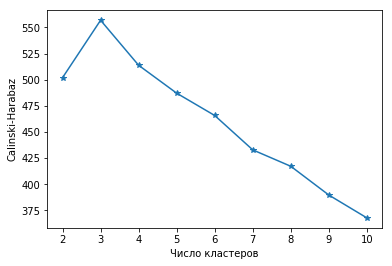

In [141]:
from sklearn.cluster import AgglomerativeClustering

J = []
params = np.arange(2, 11)
for k in params:
    ward_arc = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean') 
    # Далее будем опускать affinity='euclidean', так как это значение по умолчанию
    ward_arc.fit(X)
    J.append(calinski_harabaz_score(X, ward_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

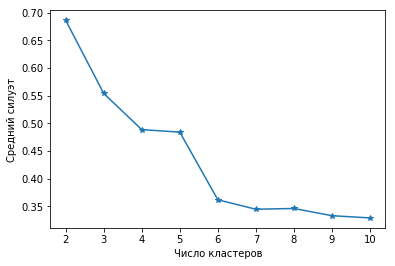

In [142]:
J = []
params = np.arange(2, 11)
for k in params:
    ward_arc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    ward_arc.fit(X)
    J.append(silhouette_score(X, ward_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Алгоритм: Ward, 3 кластера
Calinski-Harabaz: 556.8411
Средний силуэт: 0.5541


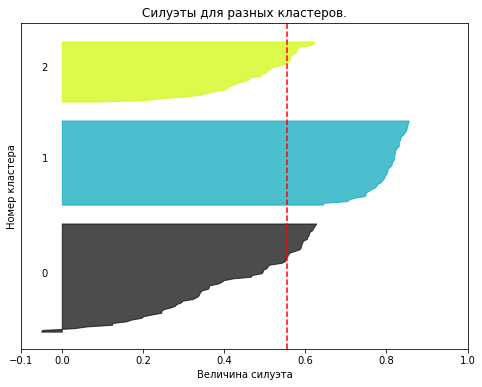

In [153]:
ward_agc = AgglomerativeClustering(n_clusters=3, linkage='ward', compute_full_tree=True)
y_ward3 = ward_agc.fit_predict(X)
estimate_cluster(X, y_ward3, 'Ward, 3 кластера')

Результаты сопоставимы с K-Means.

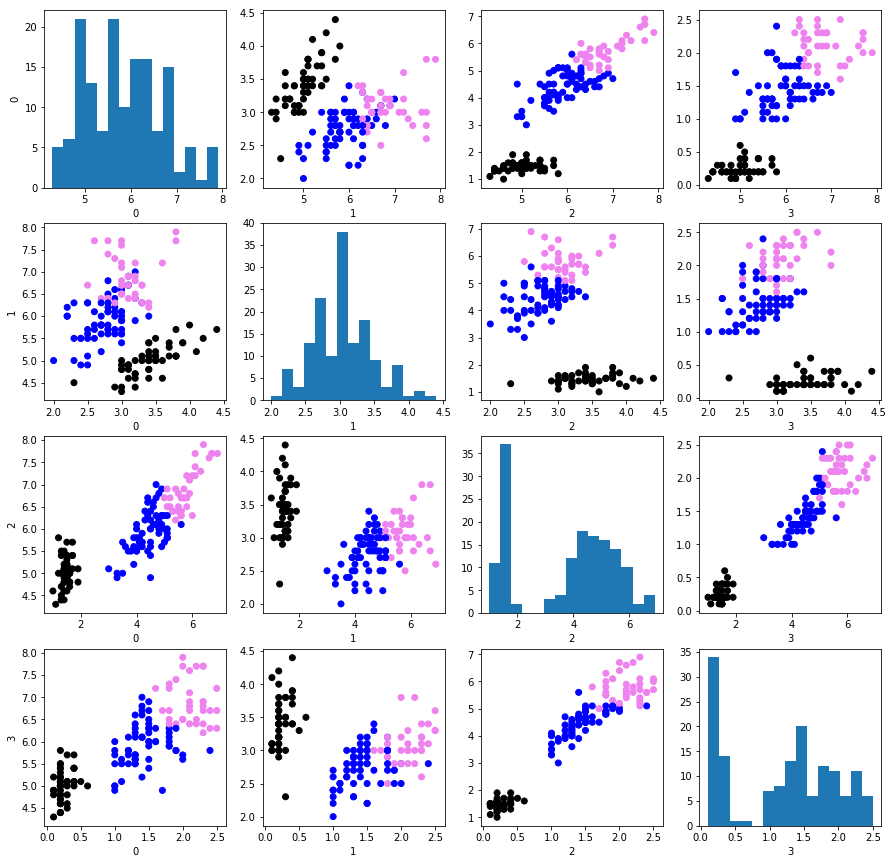

In [220]:
pairplot(X, y_ward3, np.array(['blue', 'black', 'violet']))

### Average

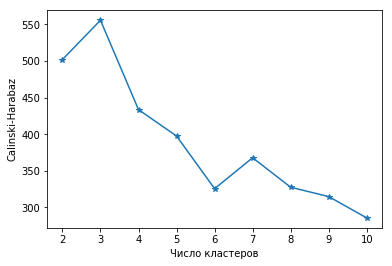

In [148]:
J = []
params = np.arange(2, 11)
for k in params:
    average_arc = AgglomerativeClustering(n_clusters=k, linkage='average')
    average_arc.fit(X)
    J.append(calinski_harabaz_score(X, average_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

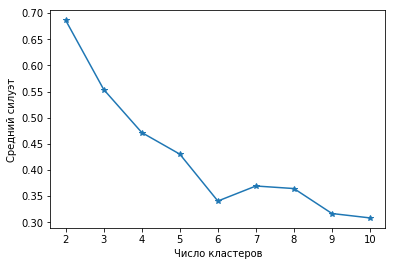

In [149]:
J = []
params = np.arange(2, 11)
for k in params:
    average_arc = AgglomerativeClustering(n_clusters=k, linkage='average')
    average_arc.fit(X)
    J.append(silhouette_score(X, average_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Алгоритм: Average, 3 кластера
Calinski-Harabaz: 555.6662
Средний силуэт: 0.5539


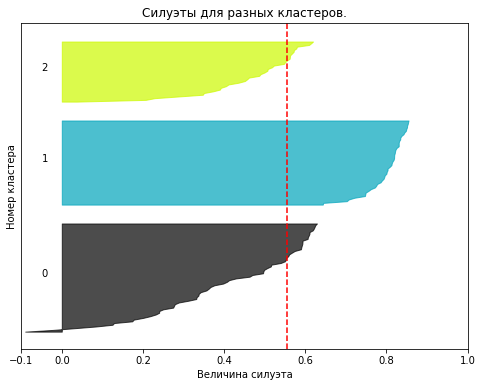

In [152]:
average_agc = AgglomerativeClustering(n_clusters=3, linkage='average', compute_full_tree=True)
y_average3 = average_agc.fit_predict(X)
estimate_cluster(X, y_average3, 'Average, 3 кластера')

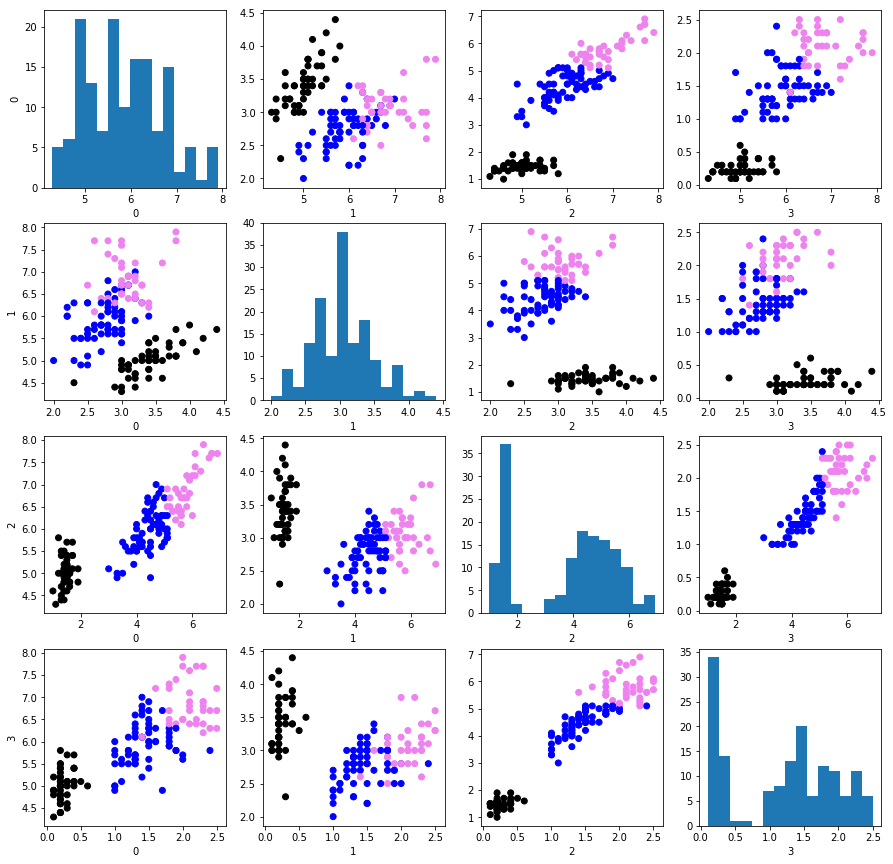

In [221]:
pairplot(X, y_average3, np.array(['blue', 'black', 'violet']))

### Complete

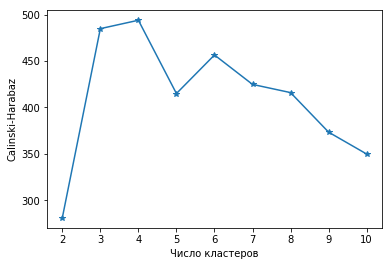

In [154]:
J = []
params = np.arange(2, 11)
for k in params:
    complete_arc = AgglomerativeClustering(n_clusters=k, linkage='complete')
    complete_arc.fit(X)
    J.append(calinski_harabaz_score(X, complete_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Calinski-Harabaz'.decode('utf-8'))
plt.show()

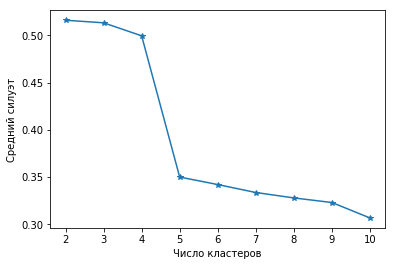

In [156]:
J = []
params = np.arange(2, 11)
for k in params:
    complete_arc = AgglomerativeClustering(n_clusters=k, linkage='complete')
    complete_arc.fit(X)
    J.append(silhouette_score(X, complete_arc.labels_))
J = np.array(J)
plt.plot(params, J, '-*')
plt.xlabel('Число кластеров'.decode('utf-8'))
plt.ylabel('Средний силуэт'.decode('utf-8'))
plt.show()

Алгоритм: Complete, 4 кластера
Calinski-Harabaz: 493.9501
Средний силуэт: 0.4996


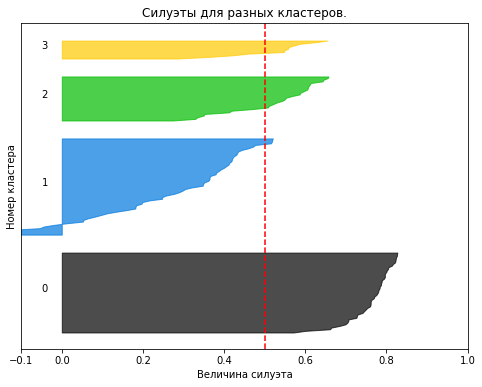

In [157]:
complete_agc = AgglomerativeClustering(n_clusters=4, linkage='complete', compute_full_tree=True)
y_complete4 = complete_agc.fit_predict(X)
estimate_cluster(X, y_complete4, 'Complete, 4 кластера')

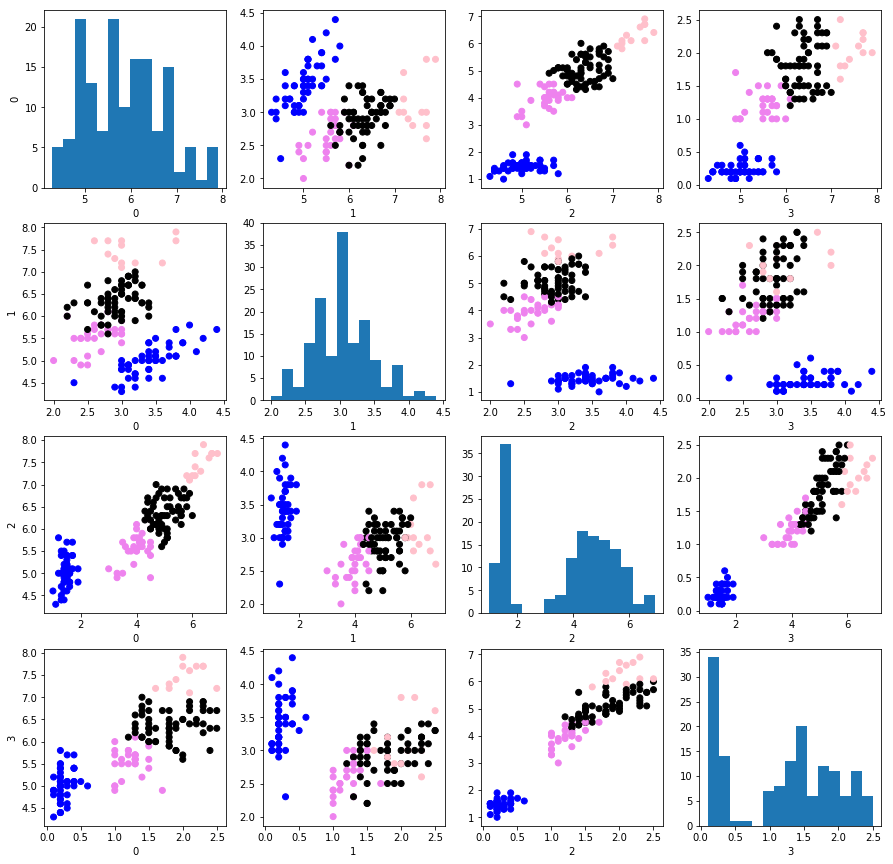

In [222]:
pairplot(X, y_complete4, np.array(['blue', 'black', 'violet', 'pink']))

Алгоритм: Complete, 3 кластера
Calinski-Harabaz: 484.8990
Средний силуэт: 0.5134


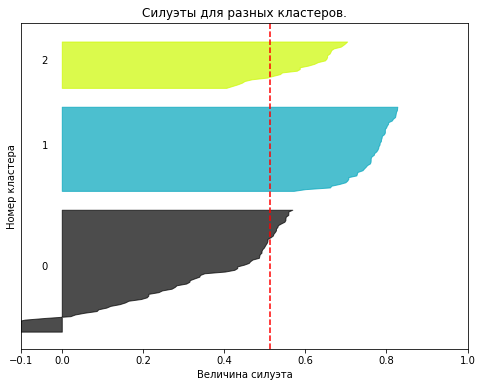

In [158]:
complete_agc = AgglomerativeClustering(n_clusters=3, linkage='complete', compute_full_tree=True)
y_complete3 = complete_agc.fit_predict(X)
estimate_cluster(X, y_complete3, 'Complete, 3 кластера')

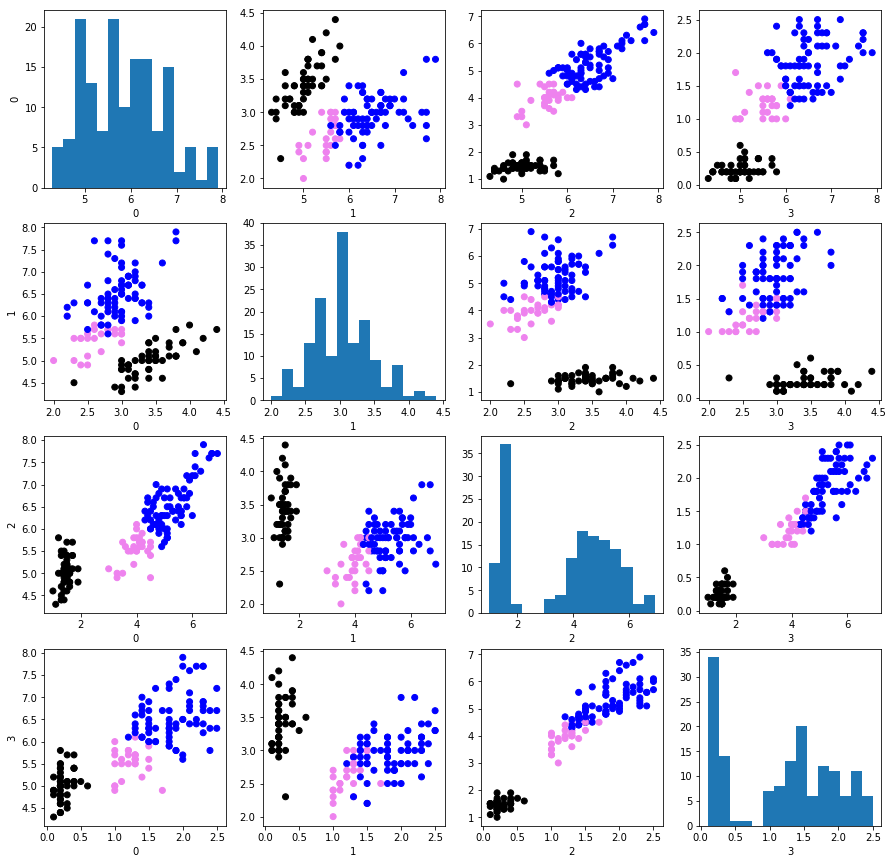

In [223]:
pairplot(X, y_complete3, np.array(['blue', 'black', 'violet']))

### Иерархическая кластеризация в SciPy

К сожалению, в sklearn есть возможность посмотреть на порядок объединения более мелких кластеров в более крупные, но без учета расстояния между ними. Но эта возможность есть в пакете SciPy. Также в sklearn отсутствует возможность оценки кофенетической корееляции. Ниже приведен пример, как это сдлеать для критерия 'ward' и евклидова расстояния в SciPy. Документация: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy

In [179]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

Z = linkage(X, method='ward', metric='euclidean') # объект для дендрограммы

c, coph_dists = cophenet(Z, pdist(X))
c

0.87260152506447042

Каждая строка Z имеет формат [idx1, idx2, dist, sample_count].

In [180]:
Z[0]

array([  9.,  34.,   0.,   2.])

На первом шаге влгоритм решил объединить кластеры с номерами 9 и 34 (объекты), так как расстояние между ними равно 0, в результате получили кластер, содержащий 2 объекта.

In [190]:
Z[130]

array([ 264.        ,  271.        ,    1.29839645,   24.        ])

In [193]:
np.set_printoptions(precision=5, suppress=True)
Z[:20]

array([[   9.     ,   34.     ,    0.     ,    2.     ],
       [  37.     ,  150.     ,    0.     ,    3.     ],
       [ 101.     ,  142.     ,    0.     ,    2.     ],
       [   7.     ,   39.     ,    0.1    ,    2.     ],
       [   0.     ,   17.     ,    0.1    ,    2.     ],
       [ 128.     ,  132.     ,    0.1    ,    2.     ],
       [  10.     ,   48.     ,    0.1    ,    2.     ],
       [  19.     ,   21.     ,    0.14142,    2.     ],
       [  29.     ,   30.     ,    0.14142,    2.     ],
       [  57.     ,   93.     ,    0.14142,    2.     ],
       [  80.     ,   81.     ,    0.14142,    2.     ],
       [ 116.     ,  137.     ,    0.14142,    2.     ],
       [   8.     ,   38.     ,    0.14142,    2.     ],
       [   3.     ,   47.     ,    0.14142,    2.     ],
       [  27.     ,   28.     ,    0.14142,    2.     ],
       [  82.     ,   92.     ,    0.14142,    2.     ],
       [  95.     ,   96.     ,    0.14142,    2.     ],
       [ 127.     ,  138.     ,

Обратите внимание, на втором шаге произошло не объединение двух объектов, а созданного на первом шаге кластера и нового объекта (объекты имеют номера от 0 до 149, так как в данных 150 объектов, поэтому 150 - это индекс кластера). Посмотрим на значения признаков объектов, попавших в кластер, созданный на втором шаге.

In [194]:
X[[9, 34, 37]]

array([[ 4.9,  3.1,  1.5,  0.1],
       [ 4.9,  3.1,  1.5,  0.1],
       [ 4.9,  3.1,  1.5,  0.1]])

Нарисуем дендрограмму.

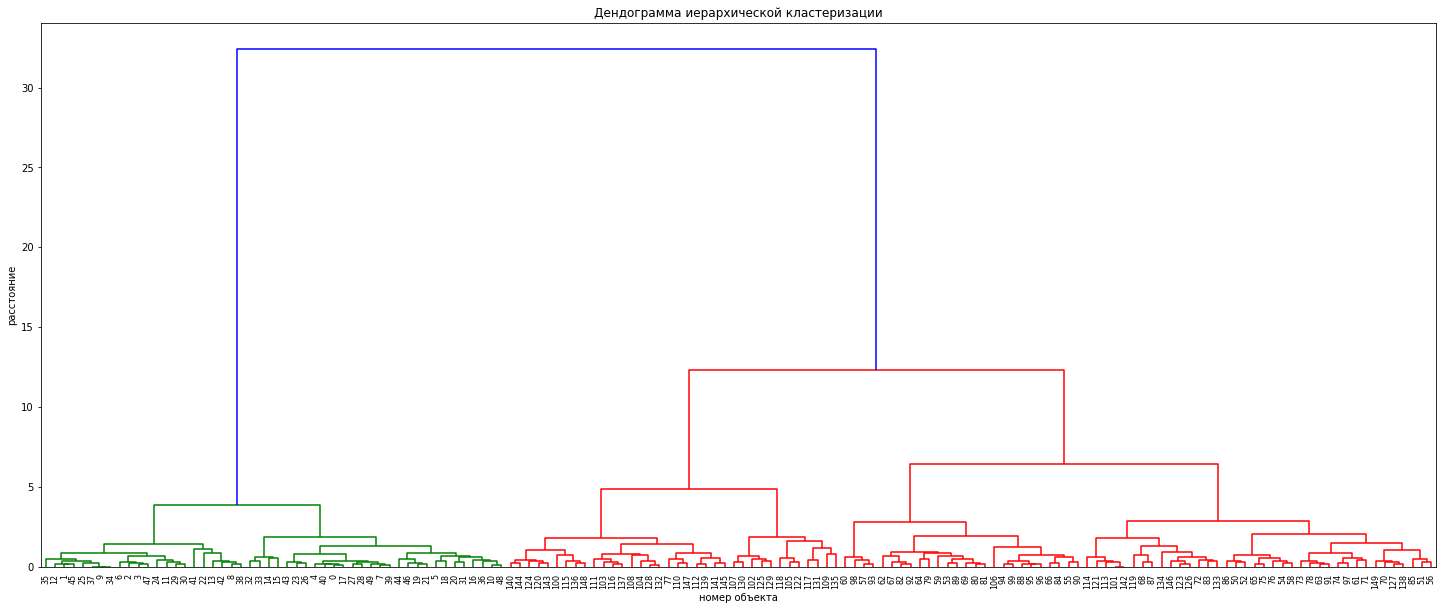

In [197]:
plt.figure(figsize=(25, 10))
plt.title('Дендограмма иерархической кластеризации'.decode('utf-8'))
plt.xlabel('номер объекта'.decode('utf-8'))
plt.ylabel('расстояние'.decode('utf-8'))
dendrogram(
    Z,
    leaf_rotation=90.,  # повернуть подписи меток на 90 градусов
    leaf_font_size=8.,  # размер подписе на оси x
)
plt.show()

Получилось громоздко, но можно сократить, исключив мелкие кластеры.

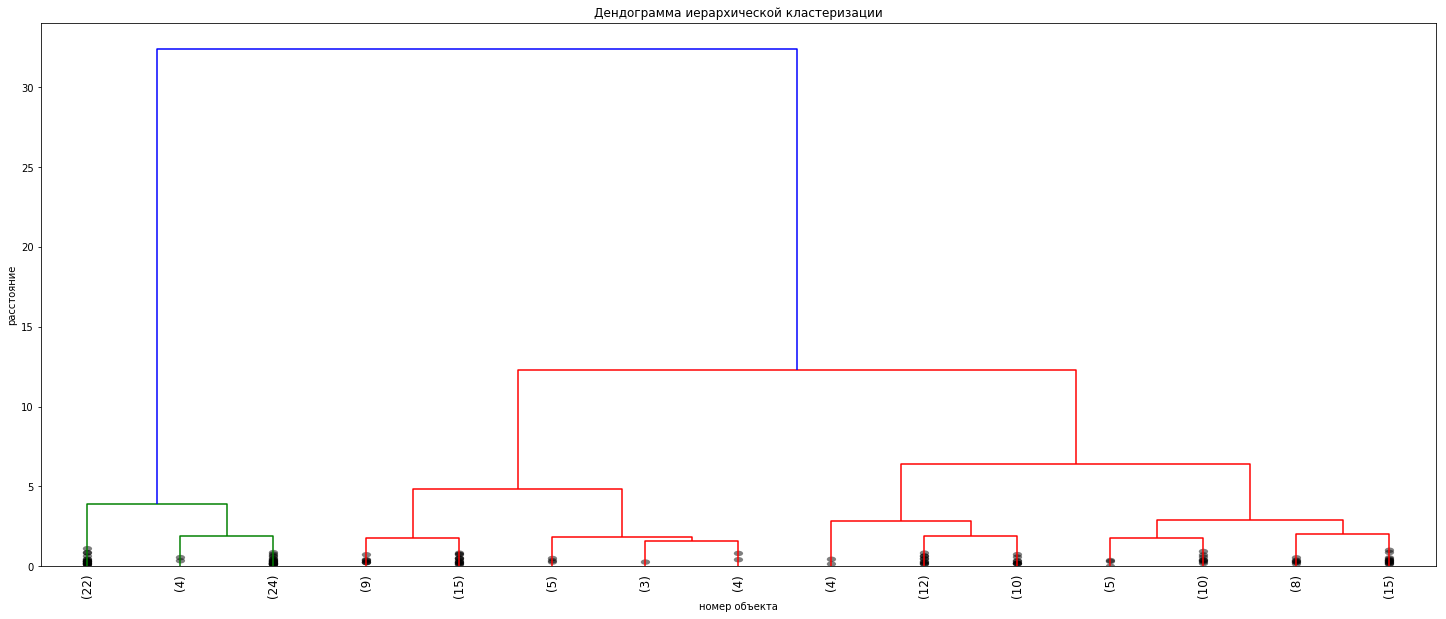

In [200]:
plt.figure(figsize=(25, 10))
plt.title('Дендограмма иерархической кластеризации'.decode('utf-8'))
plt.xlabel('номер объекта'.decode('utf-8'))
plt.ylabel('расстояние'.decode('utf-8'))
dendrogram(
    Z,
    truncate_mode='lastp',  # показать только последние p кластеров
    p=15,  # число кластеров для показа
    show_leaf_counts=True,  # показывать чило объектов в листах
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # показать распределения в сжатых ветвях
)
plt.show()

Если необходимо виидеть значения целевого показателя в кластерах и выбирать пороговое значение критерия для определения числа кластеров, можно воспользоваться функцией ниже (оригинал: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/).

In [201]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

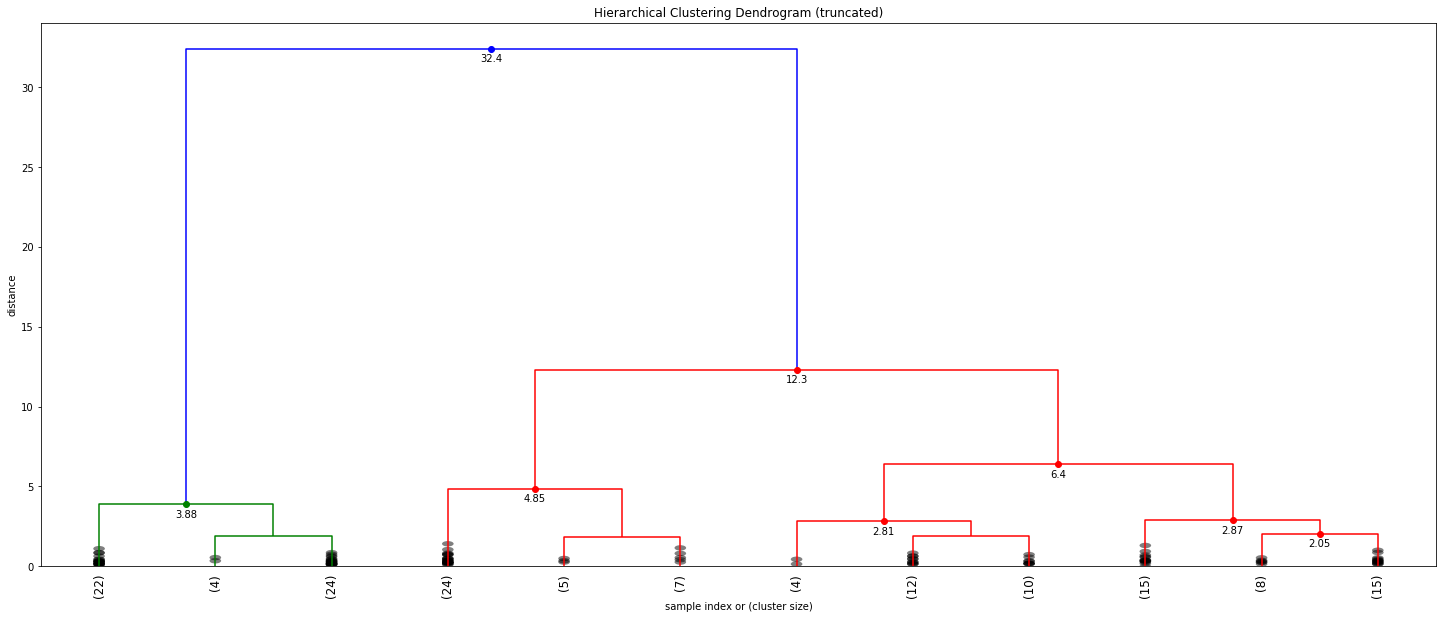

In [204]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=2,  # минимальное значение меры, при которой стоит указывать ее значение
)
plt.show()

Посмотрим, как зависит результат кластеризации от выбора порогового значения меры.

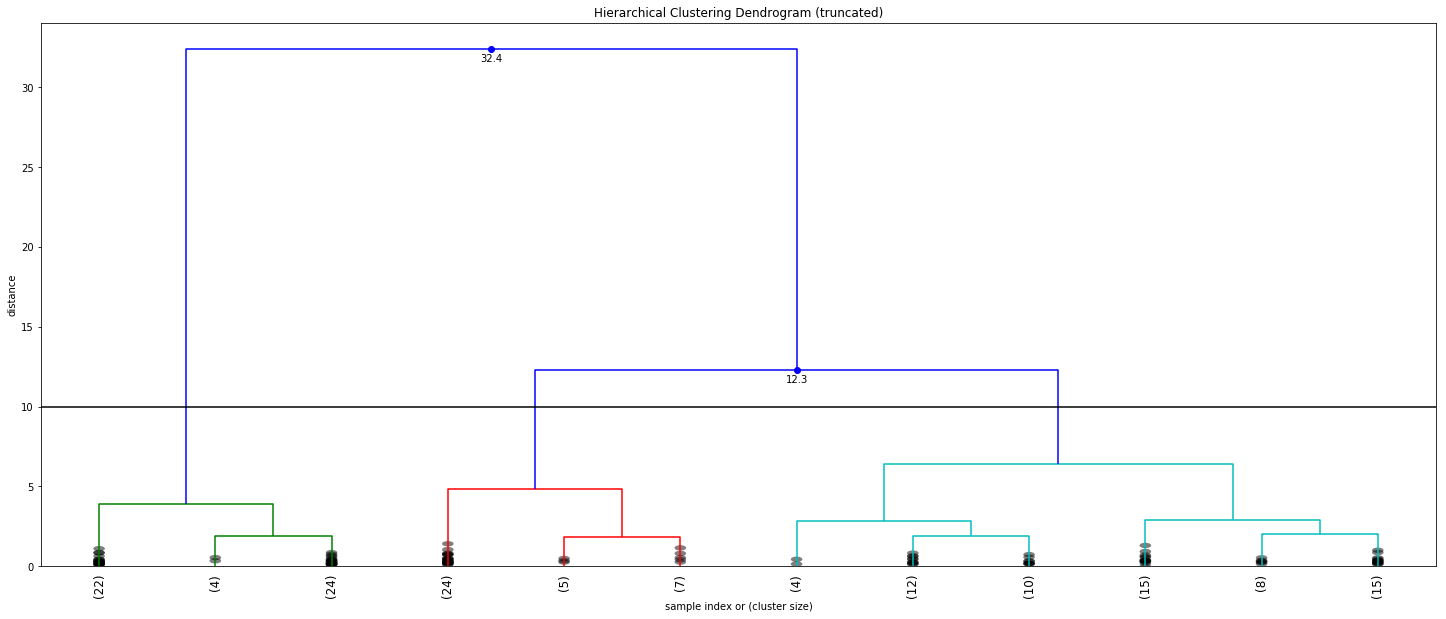

In [206]:
max_d = 10
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)
plt.show()

# DBSCAN

Документация: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

Оценка числа кластеров: 2
Среднее значение силуэта: 0.486


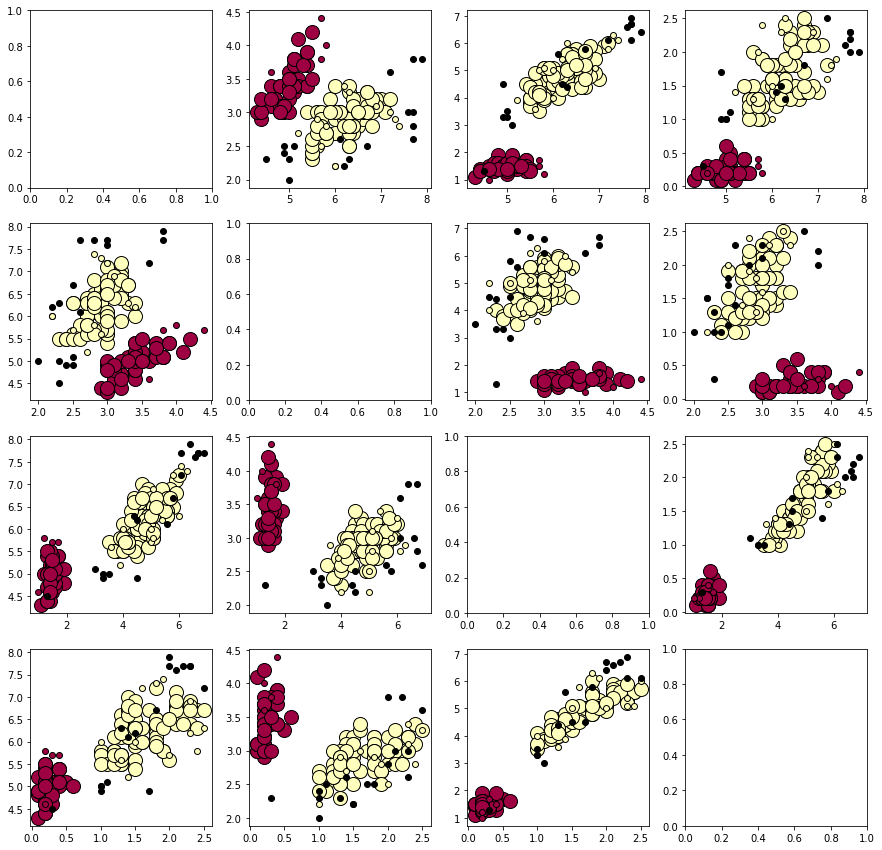

In [239]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean').fit(X) # при min_samples=5 - два кластера
                                                                
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) # создаем массив 0 таких же размеров, как и массив меток кластеров
core_samples_mask[db.core_sample_indices_] = True # массив индикаторов "внутренних точек" кластеров
labels = db.labels_

# Подсчет числа кластеров за исключением шумов.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Оценка числа кластеров: %d' % n_clusters_)
print("Среднее значение силуэта: %0.3f" % silhouette_score(X, labels))


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))] # Палетка цветов не должна включать черный.

fig, axes = plt.subplots(nrows=X.shape[1], ncols=X.shape[1], figsize=(15,15))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Черный спользуем для выбросов.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy_core = X[class_member_mask & core_samples_mask]
    xy_not_core = X[class_member_mask & ~core_samples_mask]

    for i in xrange(X.shape[1]):
        for j in xrange(X.shape[1]):
            if i != j:
                axes[i, j].plot(xy_core[:, i], xy_core[:, j], 'o', markerfacecolor=tuple(col), 
                         markeredgecolor='k', markersize=14)
                axes[i, j].plot(xy_not_core[:, i], xy_not_core[:, j], 'o', markerfacecolor=tuple(col), 
                         markeredgecolor='k', markersize=6)

Чтобы понять, как изменяется число выделяемых кластеров в зависимости от параметров eps и min_samples, можно оценить число кластеров на решетке значений.

In [261]:
eps_values = np.arange(0.4, 3, 0.1)
min_sample_values = np.arange(5, 30)
n_cluster_estimates = np.zeros((len(eps_values), len(min_sample_values)))
silhouette = np.zeros(((len(eps_values)), len(min_sample_values)))

for i, eps in enumerate(eps_values):
    for j, min_sample in enumerate(min_sample_values):
        db = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean').fit(X)
        n_cluster_estimates[i, j]  = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        if n_cluster_estimates[i, j] > 1:
            silhouette[i,j] = silhouette_score(X, db.labels_)
        else:
            silhouette[i,j] = 0

In [ ]:
eps_values = np.arange(0.4, 3, 0.1)
min_sample_values = np.arange(5, 30)
n_cluster_estimates = np.zeros((len(eps_values), len(min_sample_values)))

for i, eps in enumerate(eps_values):
    for j, min_sample in enumerate(min_sample_values):
        db = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean').fit(X)
        n_cluster_estimates[i, j]  = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

plt.figure(figsize=(10,10))        
plt.matshow(n_cluster_estimates, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

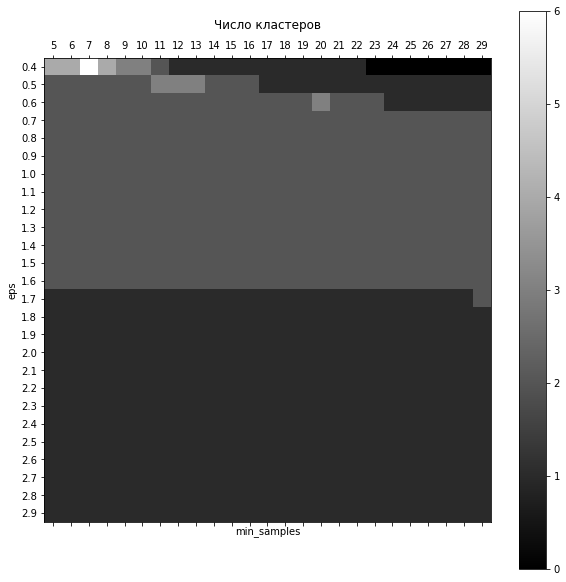

In [264]:
plt.figure(figsize=(10,10))        
plt.matshow(n_cluster_estimates, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Число кластеров'.decode('utf-8'))
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

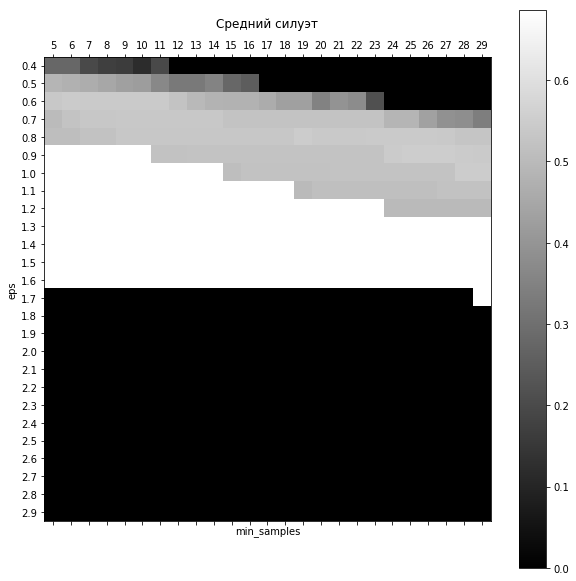

In [268]:
plt.figure(figsize=(10,10))        
plt.matshow(silhouette, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Средний силуэт'.decode('utf-8'))
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

Максимальное значение силуэта достигается для двух кластеров. Например, при eps=1.1 и min_samples=10.

Оценка числа кластеров: 2
Среднее значение силуэта: 0.686


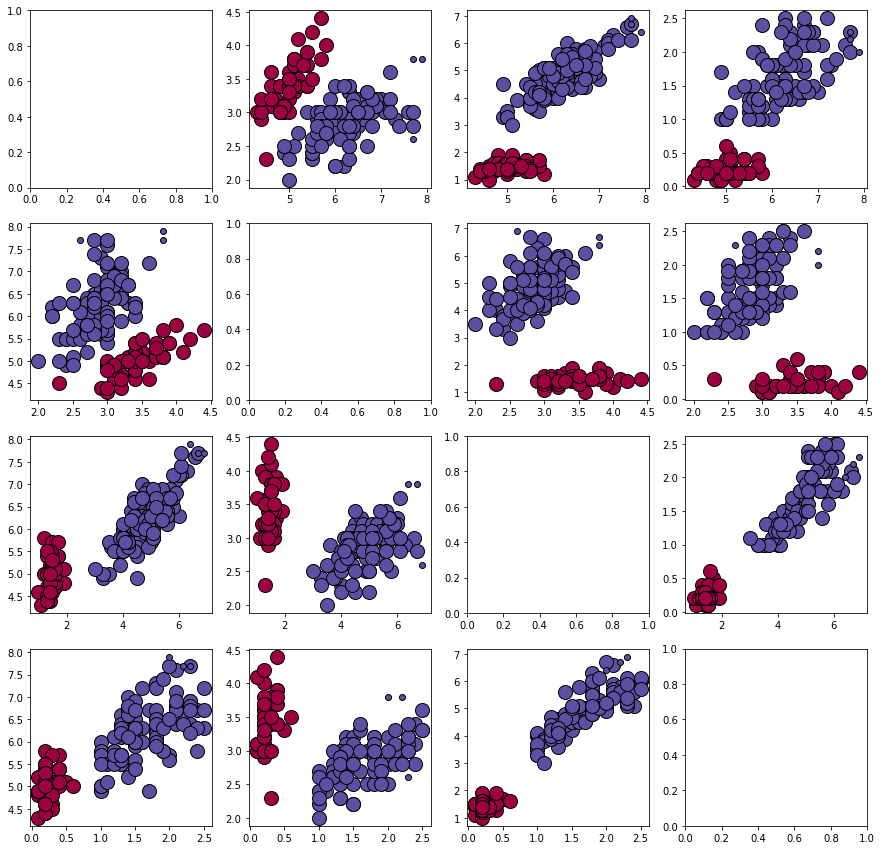

In [267]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.1, min_samples=10, metric='euclidean').fit(X)
                                                                
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) # создаем массив 0 таких же размеров, как и массив меток кластеров
core_samples_mask[db.core_sample_indices_] = True # массив индикаторов "внутренних точек" кластеров
labels = db.labels_

# Подсчет числа кластеров за исключением шумов.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Оценка числа кластеров: %d' % n_clusters_)
print("Среднее значение силуэта: %0.3f" % silhouette_score(X, labels))


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))] # Палетка цветов не должна включать черный.

fig, axes = plt.subplots(nrows=X.shape[1], ncols=X.shape[1], figsize=(15,15))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Черный спользуем для выбросов.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy_core = X[class_member_mask & core_samples_mask]
    xy_not_core = X[class_member_mask & ~core_samples_mask]

    for i in xrange(X.shape[1]):
        for j in xrange(X.shape[1]):
            if i != j:
                axes[i, j].plot(xy_core[:, i], xy_core[:, j], 'o', markerfacecolor=tuple(col), 
                         markeredgecolor='k', markersize=14)
                axes[i, j].plot(xy_not_core[:, i], xy_not_core[:, j], 'o', markerfacecolor=tuple(col), 
                         markeredgecolor='k', markersize=6)

# Спектральная кластеризация

Так как спектральная кластеризация - кластеризация на графах, небходимо для имеющихся объектов построить граф сходства. В sklearn можно не делать этого самостоятельно, а лишь выбрать способ его определения (affinity). Самая простая связывать только самые близкие по евклидовой мере объекты.

In [272]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=10, n_jobs=4).fit(X)
y_spectral_nn3 = spectral.labels_

Алгоритм: Спектральная кластеризация (nn), 3 кластера
Calinski-Harabaz: 555.6662
Средний силуэт: 0.5539


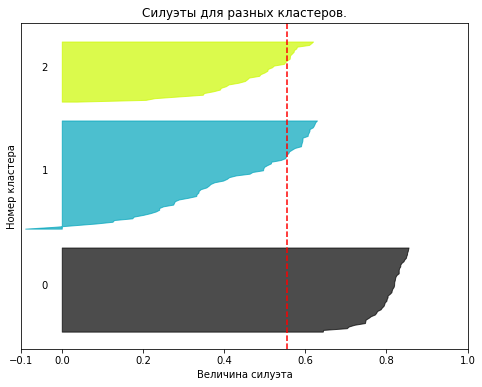

In [276]:
estimate_cluster(X, y_spectral_nn3, 'Спектральная кластеризация (nn), 3 кластера')

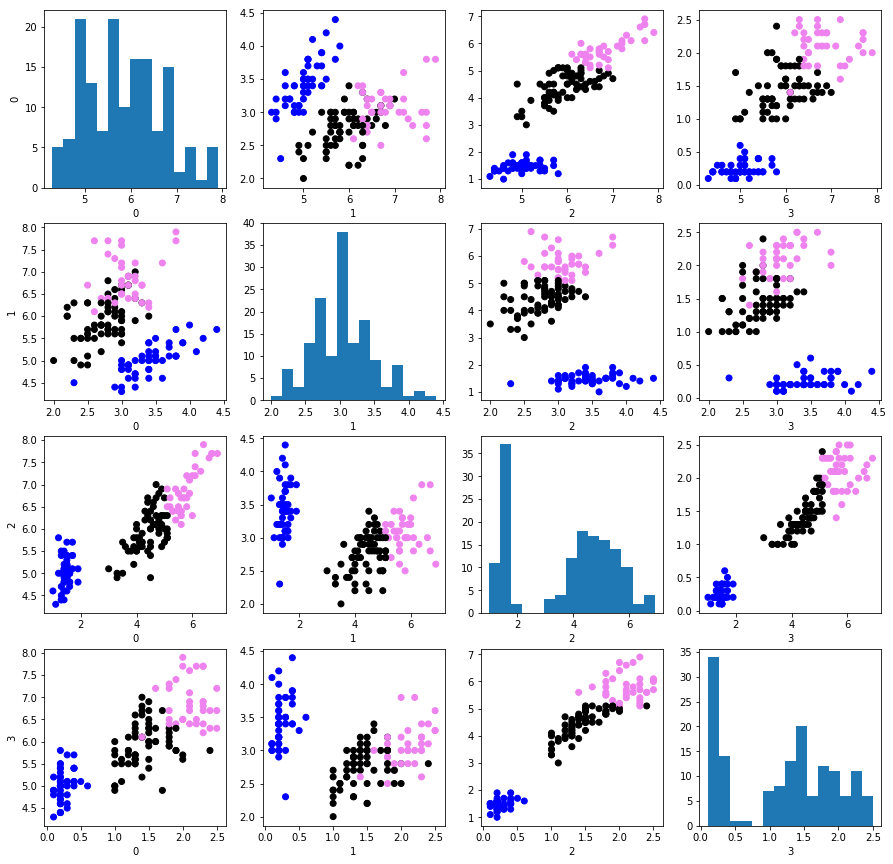

In [274]:
pairplot(X, y_spectral_nn3, np.array(['blue', 'black', 'violet']))

Другой пример, для определения сходства использовать Гауссовское ядро.

Алгоритм: Спектральная кластеризация (rbf), 3 кластера
Calinski-Harabaz: 558.9162
Средний силуэт: 0.5509


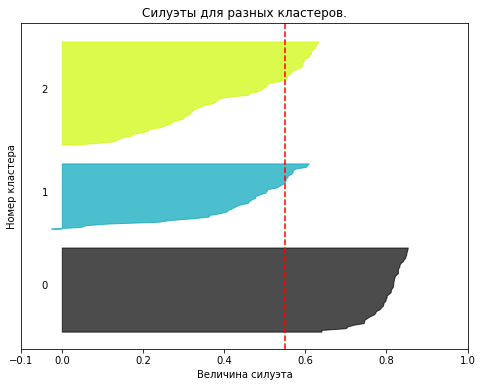

In [277]:
spectral = SpectralClustering(n_clusters=3, affinity='rbf', n_jobs=4).fit(X)
y_spectral_rbf3 = spectral.labels_
estimate_cluster(X, y_spectral_rbf3, 'Спектральная кластеризация (rbf), 3 кластера')

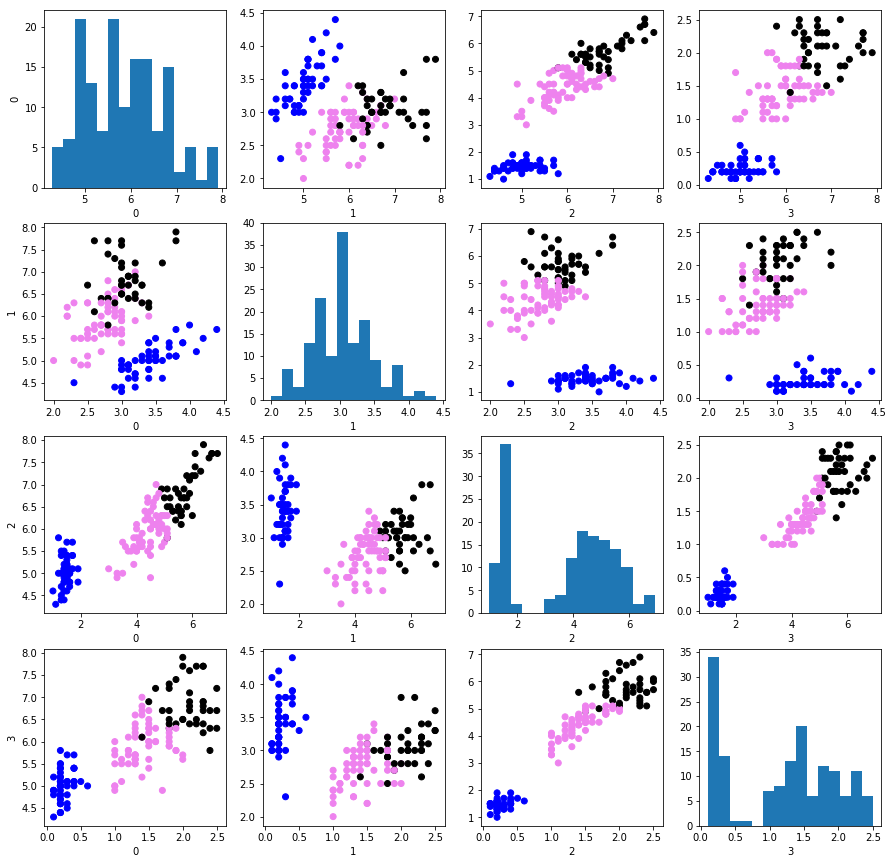

In [278]:
pairplot(X, y_spectral_rbf3, np.array(['blue', 'black', 'violet']))